In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\hyli\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, groutine, crystal

In [34]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Split
# ----------------------------------------------------------------------------------------------------------
grating_list = [crystal.SinusoidalPhaseGrating(),
                crystal.SinusoidalPhaseGrating()]

grating_list[0].set_period(1.)
grating_list[1].set_period(1.)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Pulse
# ----------------------------------------------------------------------------------------------------------

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()

energy_center = 10.
k_len = util.kev_to_wave_number(energy=energy_center)
my_pulse.polar = np.array([0., 1., 0.], dtype=np.complex128)

my_pulse.k0 = np.array([0., 0., k_len])
my_pulse.n = my_pulse.k0 / util.l2_norm(my_pulse.k0)
my_pulse.omega0 = k_len * util.c

my_pulse.sigma_x = 100.  # sigma_t
my_pulse.sigma_y = 100.  # sigma_t  # fs
my_pulse.sigma_z = 1.  # fs
my_pulse.sigma_mat = np.diag(np.array([my_pulse.sigma_x ** 2,
                                       my_pulse.sigma_y ** 2,
                                       my_pulse.sigma_z ** 2], dtype=np.float64))
my_pulse.sigma_mat *= util.c ** 2

magnitude_peak = 1.
my_pulse.scaling = complex(my_pulse.sigma_x * my_pulse.sigma_y *
                           my_pulse.sigma_z * (util.c ** 3), 0.) * magnitude_peak

pre_length = 1e6
my_pulse.x0 = np.array([0., 0., -pre_length])

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Delay
# ----------------------------------------------------------------------------------------------------------

# Some meta data for the delay line.
reflect_num = 4
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * reflect_num)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = np.abs(np.arctan(grating_list[0].wave_vector[1] / k_len))
bragg_angle_1 = np.radians(18.836) #+ 5e-4

branch_angle_1 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_1,
                                                theta=bragg_angle_1 + np.pi / 2.,
                                                rho=bragg_angle_1 - np.pi / 2.)
surface_points_1 = np.zeros((reflect_num, 3), dtype=np.float64)

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_1[0],
                                           rho_vals=branch_angle_1[1],
                                           tau_vals=branch_angle_1[2],
                                           surface_points=surface_points_1,
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - angle_offset_1
bragg_angle_2 = np.radians(18.836) 

branch_angle_2 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_2,
                                                theta=1.5 * np.pi - bragg_angle_2,
                                                rho=0.5 * np.pi - bragg_angle_2)
surface_points_2 = np.zeros((reflect_num, 3), dtype=np.float64)

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_2[0],
                                           rho_vals=branch_angle_2[1],
                                           tau_vals=branch_angle_2[2],
                                           surface_points=surface_points_2,
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))


# ----------------------------------------------------------------------------------------------------------
#                       Step 4: Arrange the crystals
# ----------------------------------------------------------------------------------------------------------
ta = 19060175
path_list_1 = [5e6 - 20e4,
               1e5,
               3e5 + 70e4,
               1.5e5,
               6e6 + ta - 50e4,
               1e4]
path_list_2 = [5e6,
               1e5,
               3e5,
               1.5e5,
               6e6 + ta,
               1e4]

(intersect_brunch_1,
 kout_brunch_1,
 intersect_brunch_2,
 kout_brunch_2) = lclsutil.get_light_path(pulse_obj=my_pulse,
                                          grating_list=grating_list,
                                          crystal_list_1=crystal_list_1,
                                          path_list_1=path_list_1,
                                          crystal_list_2=crystal_list_2,
                                          path_list_2=path_list_2)

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_1[0],
                                           rho_vals=branch_angle_1[1],
                                           tau_vals=branch_angle_1[2],
                                           surface_points=np.copy(intersect_brunch_1[1:5]),
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))
# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=reflect_num,
                                           hlen_vals=hlen_vals,
                                           theta_vals=branch_angle_2[0],
                                           rho_vals=branch_angle_2[1],
                                           tau_vals=branch_angle_2[2],
                                           surface_points=np.copy(intersect_brunch_2[1:5]),
                                           chi0=complex(-0.97631E-05, 0.14871E-06),
                                           chih_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chihbar_sigma=complex(0.59310E-05, -0.14320E-06),
                                           chih_pi=complex(0.46945E-05, -0.11201E-06),
                                           chihbar_pi=complex(0.46945E-05, -0.11201E-06))

grating_list[0].set_surface_point(np.copy(intersect_brunch_1[0]))
grating_list[1].set_surface_point(np.copy(intersect_brunch_1[-2]))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_brunch_2[-1])

total_path = pre_length + util.get_total_path_length(intersection_point_list=intersect_brunch_2)
print("The total propagation length is {:.2f}um.".format(total_path))
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#"""
(my_pulse, 
 crystal_list_1,
 crystal_list_2,
 grating_list, 
 obvservation)= lclsutil.get_split_delay_output_frame(displacement=-np.copy(intersect_brunch_1[-2]),
                                                       obvservation=observation,
                                                       pulse=my_pulse,
                                                       crystal_list_1=crystal_list_1,
                                                       crystal_list_2=crystal_list_2,
                                                       grating_pair=grating_list)
#"""
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 2
number_z = 10 ** 4
kx_grid, ky_grid, kz_grid, axis_info = lclsutil.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=5e-5,
                                                              delta_e_z=1e-2 / util.c)
kz_grid += k_len

# Apply fft shift
#kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
#ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
ky_grid = np.zeros(1, np.float64)
number_y = 1
#kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

The total propagation length is 31620175.00um.


In [35]:
# Set the range of the index to save
z_idx_range = 10 ** 6
num1 = 10 ** 6 - 50
num2 = 50
d_num = 512

# -------------------------------------------------------------
#            Get Field for Branch 1
# -------------------------------------------------------------
grating_list[0].set_order(-1)
grating_list[1].set_order(1)


tic = time.time()

(result_3d_dict,
 result_2d_dict,
 check_dict) = groutine.get_single_branch_split_delay_field(grating_pair = grating_list,
                                                            channel_cuts = crystal_list_1,
                                                            total_path = total_path, 
                                                            observation = observation,
                                                            my_pulse = my_pulse,
                                                            kx_grid = kx_grid,
                                                            ky_grid = ky_grid,
                                                            kz_grid = kz_grid,
                                                            number_x = number_x,
                                                            number_y = number_y,
                                                            number_z = number_z,
                                                            z_idx_range = z_idx_range,
                                                            num1 = num1,
                                                            num2 = num2, 
                                                            d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to finish the calculation".format(toc - tic))

It takes 0.40 seconds to prepare the variables.
It takes 0.56 seconds to finish the calculation


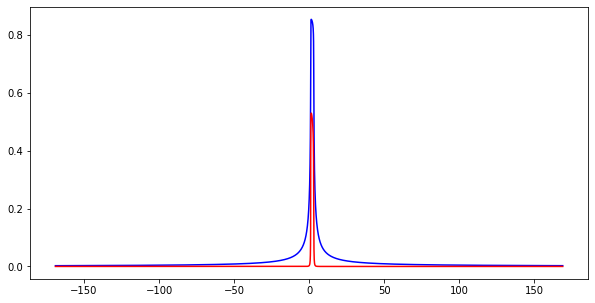

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(kz_grid - k_len,np.abs(check_dict['reflectivity_pi']),'b')
plt.plot(kz_grid - k_len,np.abs(check_dict['reflectivity_pi_tot']),'r')

plt.show()

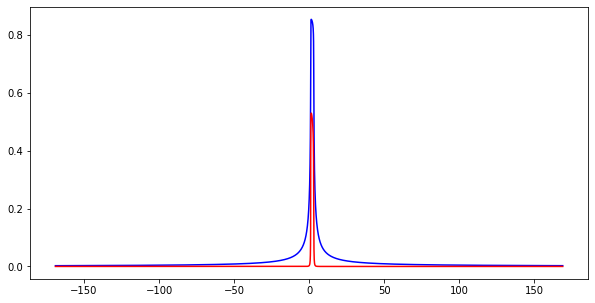

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(kz_grid - k_len,np.abs(check_dict['reflectivity_pi']),'b')
plt.plot(kz_grid - k_len,np.abs(check_dict['reflectivity_pi_tot']),'r')

plt.show()